<a href="https://colab.research.google.com/github/jeonggunlee/DeepLearningBasics/blob/master/Lab10_MEDICAL/skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 피부암 분류

데이터 다운로드: https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign/metadata

참고 자료: https://www.kaggle.com/fanconic/efficientnetb3-approach-test-auc-0-920

첨부한 파일을 모두 google drive에 업로드해야 합니다.
  - efficientnet-0.0.3-py2.py3-none-any.whl -> efficientnet 설치를 위한 파일
  - skin-cancer-malignant-vs-benign.zip -> 데이터셋
  - efficientnet-b3_imagenet_1000_notop.h5 -> pretrained 된 efficientnet의 weight

**1. 링크를 클릭**

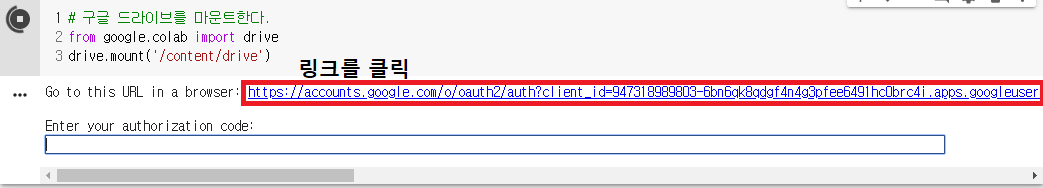

**2. 구글 로그인 후 액세스 허용**

# 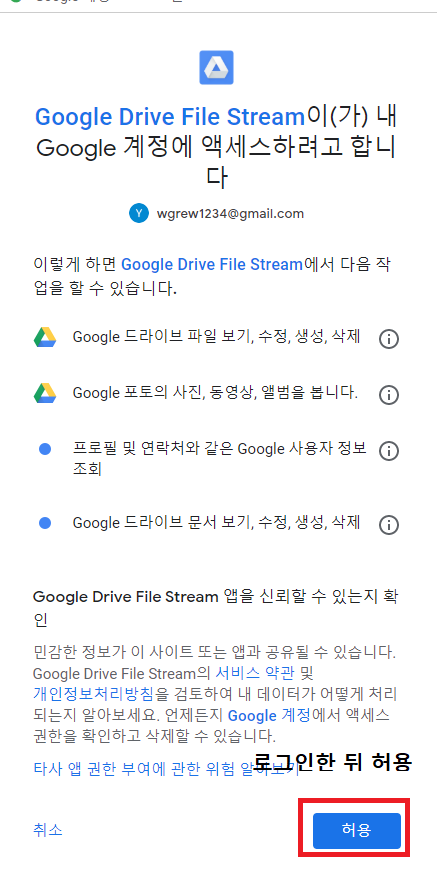

**3. 코드 복사 후 붙여넣기 그리고 엔터**

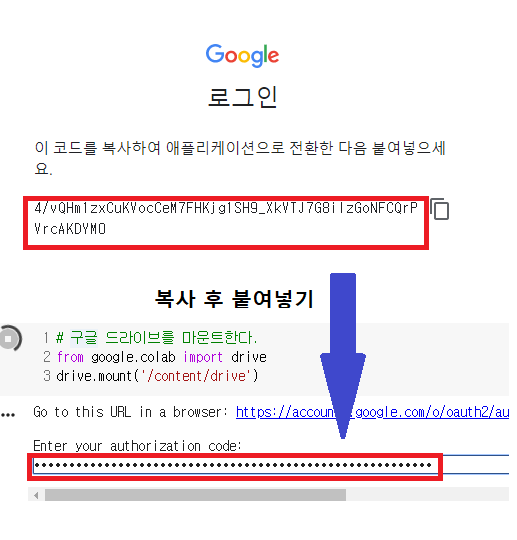

In [0]:
# 구글 드라이브를 마운트한다.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# efficientnet 패키지를 설치
!pip install -U '/content/drive/My Drive/efficientnet-0.0.3-py2.py3-none-any.whl'

Processing ./drive/My Drive/efficientnet-0.0.3-py2.py3-none-any.whl


In [0]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# 학습 데이터 압축 풀기
!7z x /content/drive/My\ Drive/skin-cancer-malignant-vs-benign.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/                                  1 file, 170237869 bytes (163 MiB)

Extracting archive: /content/drive/My Drive/skin-cancer-malignant-vs-benign.zip
--
Path = /content/drive/My Drive/skin-cancer-malignant-vs-benign.zip
Type = zip
Physical Size = 170237869

  0%      0% 5 - data/test/benign/1003.jpg                                    0% 17 - data/test/benign/105.jpg                                    0% 26 - data/test/benign/1092.jpg                                   

위 데이터를 받을 때, kaggle에서 받아도 됩니다!

!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign


---



In [0]:
# 필요한 패키지 import
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools


%matplotlib inline

Using TensorFlow backend.


# **Loading & Preprocessing**
benign: 양성

malignant: 악성

In [0]:
# DIR 디렉토리 내의 jpg 이미지들을 RESIZE X RESIZE 크기로 변환한 뒤 array 형태로 변환
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG

# train 데이터와 test 데이터를 모두 변환
benign_train = np.array(Dataset_loader('data/train/benign',224))
malign_train = np.array(Dataset_loader('data/train/malignant',224))
benign_test = np.array(Dataset_loader('data/test/benign',224))
malign_test = np.array(Dataset_loader('data/test/malignant',224))

100%|██████████| 300/300 [00:00<00:00, 658.35it/s]


# **Create Labal**

In [0]:
# train과 test 데이터의 label 만들기
# 양성의 label은 0, 악성의 label은 1
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# 학습을 위해 양성 train 데이터와 악성 train 데이터를 train 데이터로 합치고
# 양성 test 데이터와 악성 test 데이터를 test 데이터로 합친다.
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# train data를 셔플
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# test data를 셔플
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# 0(양성) -> [1,0], 1(악성) -> [0,1]로 원핫인코딩한다.
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# **Train and Evaluation split**

In [0]:
# train 데이터의 20%를 분리하여 validation 데이터로 만든다.
# from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2,          # Test Data로 사용할 비율
    random_state=11         # randome seed
)

# **Display Some Images**

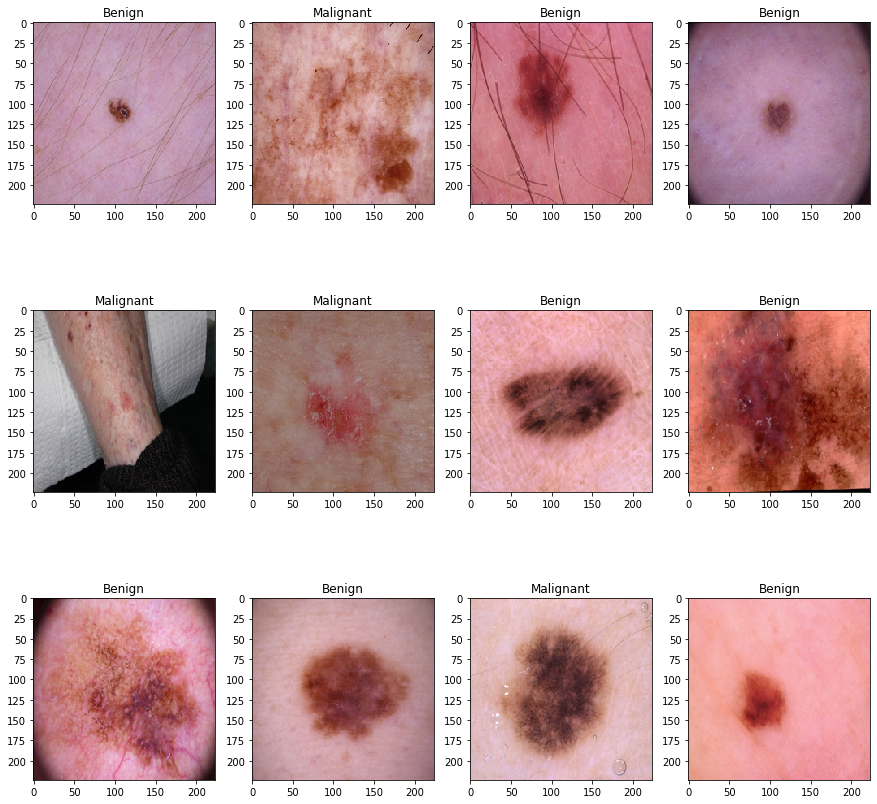

In [0]:
# 어떤 이미지들이 있는지 확인해보기
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

# 12개의 이미지 출력 (1이상 13미만)
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# **Data Generator**

In [0]:
# Robustness 증가를 위해 이미지에 가우시안 노이즈를 추가
def preprocess_image(image):
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,20), -4, 128)
    return image

In [0]:
# batch size는 32
BATCH_SIZE = 32

# 이미지 augmantation과 normalization
train_datagen = ImageDataGenerator(rescale=1./255,
                                   #rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.1,
                                   zoom_range=(0.7,1),
                                   fill_mode= 'constant',
                                   cval = 0,
                                   brightness_range=(0.5,1.5),
                                   #preprocessing_function=preprocess_image,
                                  )

val_datagen = ImageDataGenerator(rescale=1./255,
                                 #preprocessing_function=preprocess_image,
                                  )

test_datagen = ImageDataGenerator(rescale=1./255,
                                 #preprocessing_function=preprocess_image,
                                  )

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle= False)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)

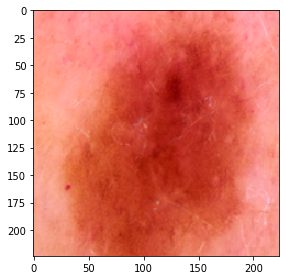

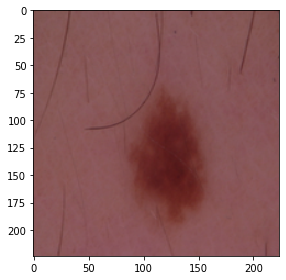

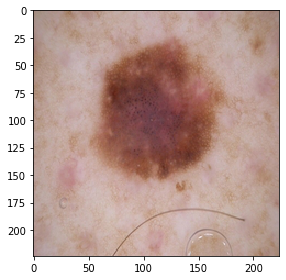

In [0]:
# augmantation과 normalization을 거친 이미지 출력해보기
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x1, y1 = train_generator[0]
x2, y2 = val_generator[0]
x3, y3 = test_generator[0]

imshow(x1[0])
imshow(x2[0])
imshow(x3[0])

# **Model**

In [0]:
# backbone=efficientnetb3에 레이어 추가하여 모델을 build
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    return model

In [0]:
# 모델 구현
from efficientnet import EfficientNetB3
K.clear_session()
gc.collect()

# efficientnetb3 모델을 로드
efficientnetb3 = EfficientNetB3(
        weights=None,
        input_shape=(224,224,3),
        include_top=False
                   )

# 기학습된 weight를 불러온다.
efficientnetb3.load_weights("/content/drive/My Drive/efficientnet-b3_imagenet_1000_notop.h5")

# 모델 확인해보기
model = build_model(efficientnetb3)
model.summary()
#efficientnetb3.summary()

# loss function은 binary crossentropy
# 학습률은 1e-4로 시작
# decay는 학습률의 감소율
# 학습 중 accuracy를 저장한다.
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=1e-4,decay=1e-6),
        metrics=['accuracy']
    )














Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 1536)              6144      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3074      
Total params: 10,792,746
Trainable params: 10,

In [0]:
# 한 번 학습시켜보기
history = model.fit_generator(
    train_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=1,
    validation_data=val_generator,
    validation_steps = x_val.shape[0] // BATCH_SIZE,
)



Epoch 1/1
65/65 [==============================] - 87s 1s/step - loss: 0.6767 - acc: 0.7050 - val_loss: 0.4328 - val_acc: 0.8105


In [0]:
# 학습이 진행됨에 따라 learning rate를 조절하는 learning rate reducer
# patience: 5 epoch 동안 성능이 개선되지 않으면 learning rate를 조절
# factor: new_learning_rate = learning rate * factor
# min_lr : learning rate 가능한 최소값 = 1e-7
learn_control = ReduceLROnPlateau(monitor='val_acc', 
                                  patience=5,
                                  verbose=1,
                                  factor=0.2, 
                                  min_lr=1e-7)

# 학습하면서 성능이 좋았을 때를 checkpoint로 저장
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# **Training & Evaluation**

In [0]:
# 학습시키기
# epoch(학습 횟수)를 증가시키면 성능이 더 상승한다.
history = model.fit_generator(
    train_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    validation_steps = x_val.shape[0] // BATCH_SIZE,
    callbacks=[learn_control, checkpoint]
)

Epoch 1/10
65/65 [==============================] - 47s 720ms/step - loss: 0.4940 - acc: 0.8014 - val_loss: 0.3737 - val_acc: 0.8398

Epoch 00001: val_acc improved from -inf to 0.83984, saving model to weights.best.hdf5
Epoch 2/10
65/65 [==============================] - 47s 728ms/step - loss: 0.4549 - acc: 0.8177 - val_loss: 0.3430 - val_acc: 0.8468

Epoch 00002: val_acc improved from 0.83984 to 0.84677, saving model to weights.best.hdf5
Epoch 3/10
65/65 [==============================] - 47s 729ms/step - loss: 0.4354 - acc: 0.8190 - val_loss: 0.3391 - val_acc: 0.8427

Epoch 00003: val_acc did not improve from 0.84677
Epoch 4/10
65/65 [==============================] - 47s 723ms/step - loss: 0.3742 - acc: 0.8494 - val_loss: 0.3157 - val_acc: 0.8629

Epoch 00004: val_acc improved from 0.84677 to 0.86290, saving model to weights.best.hdf5
Epoch 5/10
65/65 [==============================] - 47s 721ms/step - loss: 0.3879 - acc: 0.8417 - val_loss: 0.3317 - val_acc: 0.8649

Epoch 00005: val

In [0]:
# 학습 기록 저장
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

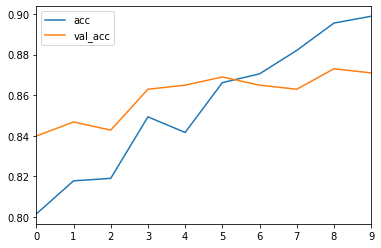

In [0]:
# accuracy의 변화 출력
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

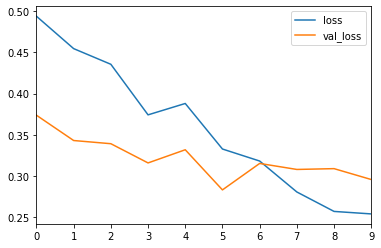

In [0]:
# loss의 변화 출력
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# **Prediction**

In [0]:
# validation 데이터의 accuracy가 가장 높았던 떄의 weights를 load
model.load_weights("weights.best.hdf5")

In [0]:
# validation 데이터의 accuracy 출력해보기
val_generator.reset()
Y_val_pred = model.predict_generator(val_generator, steps=np.ceil(x_val.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.865530303030303

In [0]:
# test 데이터의 accuracy 출력해보기
test_generator.reset()
Y_pred = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8560606060606061

# **Test Time Augmantation**

Test Time Augmantation: augmantation 이미지를 여러번 보여준 다음 각각의 단계에 대해서 prediction을 평균하고 이 결과를 최종값으로 사용

In [0]:
# test 데이터에 TTA 적용
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    test_generator = train_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)
    preds = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
    predictions.append(preds)

    del test_generator
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [01:22<00:00,  8.26s/it]


# **Evaluation**



Accuracy Score

In [0]:
# 일반 test 데이터의 accuracy
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8560606060606061

In [0]:
# TTA를 거친 test 데이터의 accuracy
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

0.8742424242424243

Confusion Matrix

Confusion matrix, without normalization
[[320  40]
 [ 55 245]]


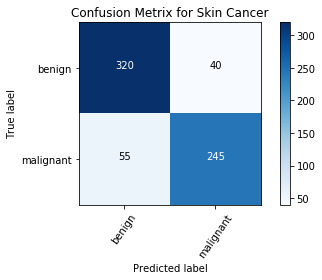

In [0]:
# confusuin matrix 그리기
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# 일반 test 데이터 결과로 생선된 confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[313  47]
 [ 36 264]]


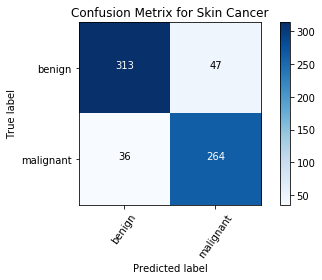

In [0]:
# TTA가 적용된 test 데이터롤 생성된 confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

**ROC curve and AUC**

ROC: Receiver Operating Characteristic curve

AUC: Area Under the Curve

ROC curve 아래 영역이 AUC이다. AUC가 넓을 수록 성능이 좋은 것이다.

 - True positive rate: True positive / (True positive + False Negative)

 - False positive rate: False positive / (False positive + True Negative)

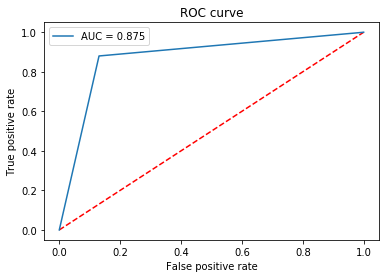

In [0]:
# ROC curve와 AUC를 그려본다.

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

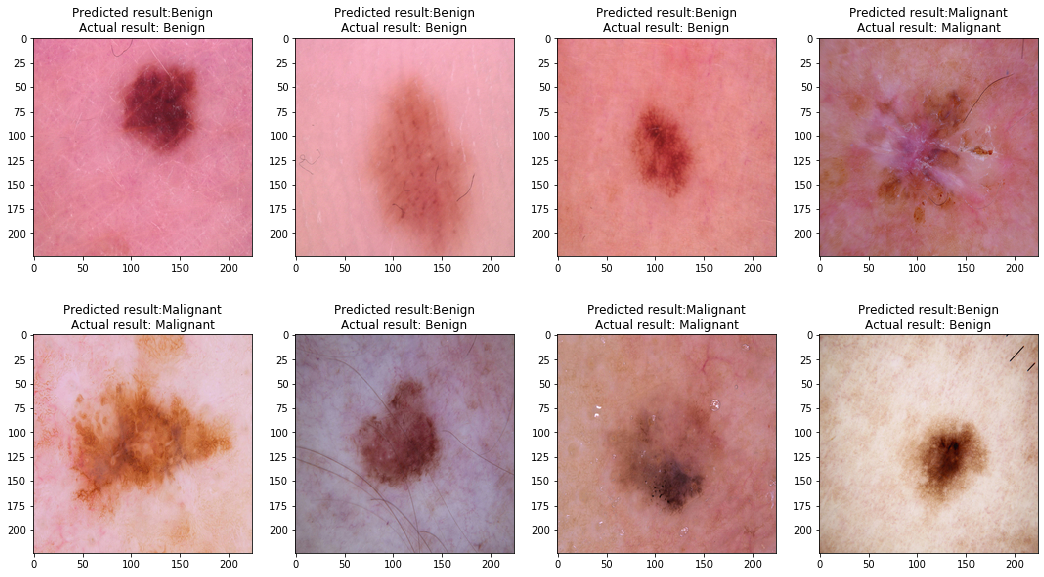

In [0]:
i=0
prop_class=[]
mis_class=[]

# 제대로 구분한 데이터를 'prop_class' list로
for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

# 잘못 판단한 데이터를 'miss_class' list로
i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

# 분류 결과가 0이면 양성 1이면 음성
def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
# 제대로 판단한 데이터 출력해보기
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

# **Save Model**

In [0]:
# 모델과 학습 결과 저장하기
model_json = model.to_json()

with open("efficientnet.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("efficientnet.h5")
print("Saved model to disk")

Saved model to disk
